# Прогнозирование вероятности оттока пользователей для фитнес-центров

**Цель** – провести анализ и подготовить план действий по удержанию клиентов.

**Задачи:**
1. Обзор данных;
2. Исследование данных;
3. Прогноз вероятности оттока;
4. Группировка клиентов;
5. Анализ признаков влияющих на отток;
6. Выводы и рекомендации по повышению качества работы с клиентами.

**Описание данных**

Данные на месяц до оттока и факт оттока на определённый месяц.

Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Импорт данных
try:
    df = pd.read_csv('/datasets/gym_churn.csv') 

except:
    df = pd.read_csv(r'gym_churn.csv') 

## Исследовательский анализ данных (EDA)

Проведем предварительный обзор данных.

In [3]:
# функция для обзора данных
def first_look(df):
    print('----------Первые 5 строк----------')
    display(df.head())
    print('\n')
    print('----------Тип данных----------')
    display(df.info())
    print('----------Статистика данных----------')
    display(df.describe())
    print('----------Пропуски в данных----------')
    df_isna = df.isna().sum()
    if df_isna.sum() > 0:
        print(df_isna)
    else: print('Пропусков нет')
    print('----------Количество явных дубликатов----------')
    print(df.duplicated().sum())

In [4]:
first_look(df)

----------Первые 5 строк----------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_tot

None

----------Статистика данных----------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


----------Пропуски в данных----------
Пропусков нет
----------Количество явных дубликатов----------
0


In [5]:
# приведём к необходимому регистру gender
df = df.rename(columns={'gender' : 'Gender'})

- Все признаки присутствуют;
- Пропусков в данных не обнаружено;
- 6 призанаков бинарные, не вклюячая целевой;
- Средний возраст клиентов 29 лет;

Скорее всего будут скоррелированны следующие характеристики (у них достаточно похожая статистика):

- Средний срок до окончания текущего действующего абонемента – среднее время с момента первого обращения в фитнес-центр – длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- Cредняя частота посещений в неделю за все время с начала действия абонемента – средняя частота посещений в неделю за предыдущий месяц.

Рассмотрим статистику признаков между группами – тех, кто попал в отток и тех, кто остался.
Сначала рассмотрим среднее.

In [6]:
df.groupby('Churn').mean().T

Churn,0,1
Gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


Отток в среднем меньше если:
- клиенты являются сотрудниками компаний благодаря которым имеют скидки на абонемент ('Partner');
- имеется факт первоначальной записи в рамках акции «приведи друга» ;
- клиент посещает групповые занятия;
- период контракта 6 месяцев;
- больше тратит на другие услуги;
- клиент только начал ходить;
- клиент ходит в клуб 4 месяца с начала первого обращения;
- клиент ходит в клуб в среднем 2 раза в неделю.

Отток в среднем больше если (небинарные признаки):
- до окончания контракта осталось 2 месяца;
- клиент ходит в клуб только в течение 1-го месяца с начала первого обращения;
- клиент ходит в клуб в среднем 1 раз в неделю.

Теперь посмотрим на гистограммы распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

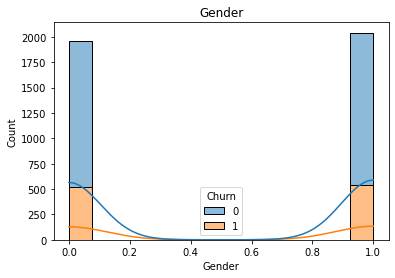

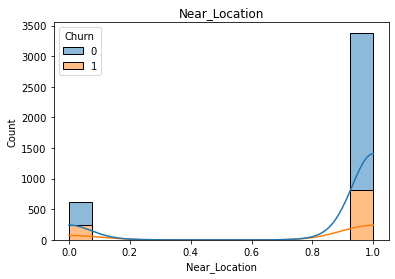

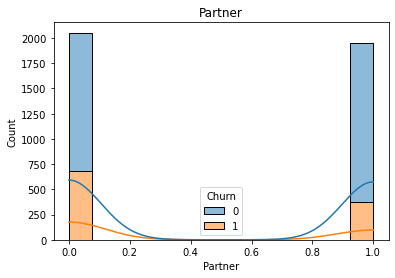

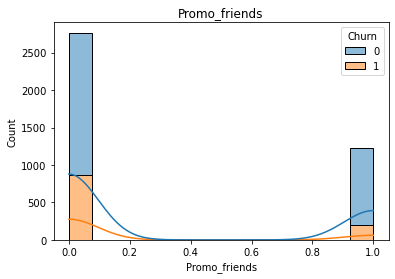

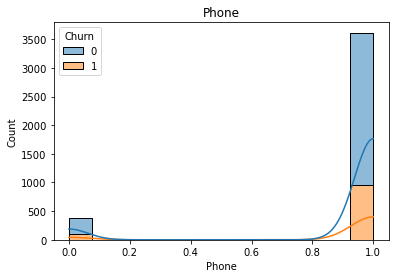

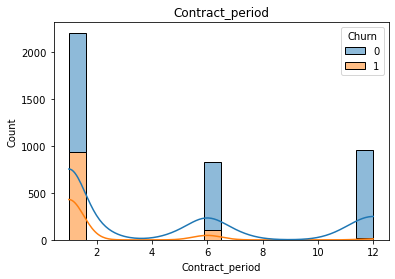

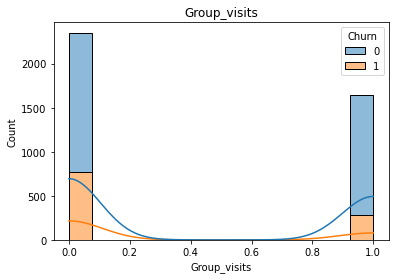

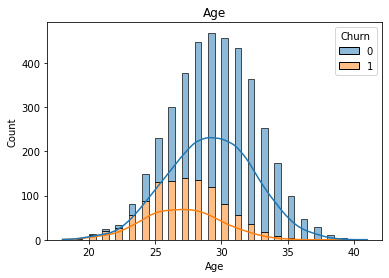

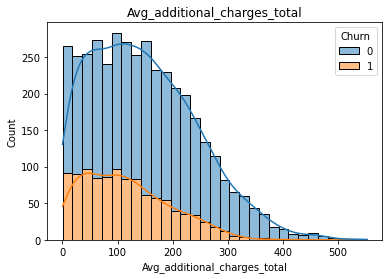

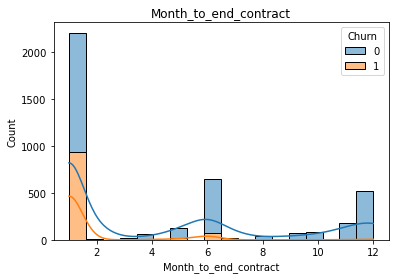

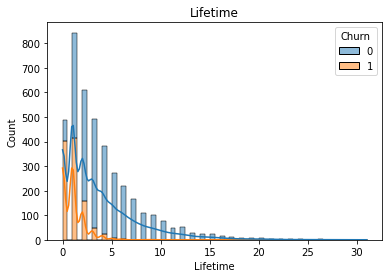

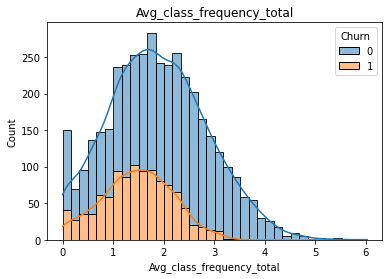

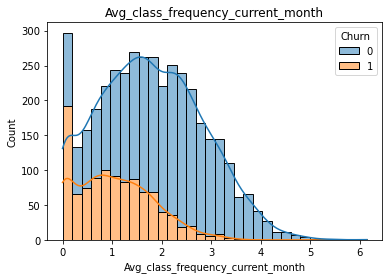

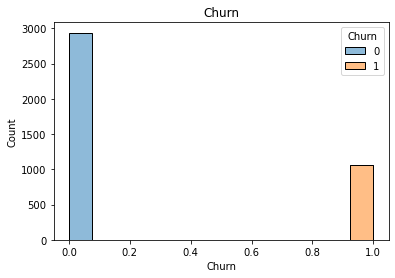

In [7]:
for feature in df.columns:
    sns.histplot(data=df, x=feature, hue='Churn', kde=True, multiple="stack");
    plt.title(feature)
    plt.show(); 
    warnings.filterwarnings("ignore")

- Гораздо больше клиентов проживет или работает в районе, где находится фитнес-центр. Клиенты живущие и работающие рядом чуть меньше подвержены оттоку.
- Промокоды от друзей получили примерно половина клиентов. С промокодами отток меньше.
- Подавляющее большинство дало контактный телефон;
- Половина клиентов имеют месячные абонементы. Шестимесячные и двенадцатимесячные контракты распределились примрно поровну и отток у них минимальный.
- С возрастом доля оттока уменьшается.
- Частота посещений за месяц до оттока в разы увеличивается.

Посмотрим на корреляционную матрицу.

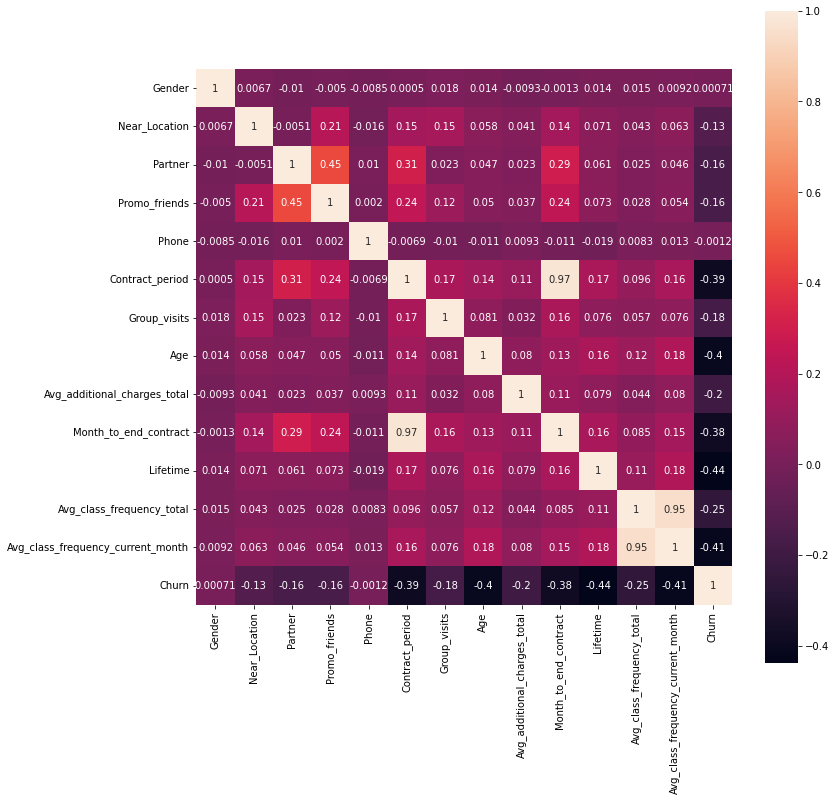

In [8]:
#построим и отрисуем матрицу корреляций
df_corr = df.corr() #вычисляем матрицу корреляций

#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, annot=True, square=True);

Признаки с высокой корреляцией:
- Средний срок до окончания текущего действующего абонемента – длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- Cредняя частота посещений в неделю за все время с начала действия абонемента – средняя частота посещений в неделю за предыдущий месяц.

## Модель прогнозирования оттока клиентов 

Разделим датафреййм на признаки (матрица X) и целевую переменную (y)

In [9]:
X = df.drop(columns='Churn')
y = df['Churn']

### Стандартизация

До обучения моделей следует привести признаки к единому масштабу. Стандартизируем данные.

In [10]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X) # обучите scaler на обучающей выборке методом fit
X_st = scaler.transform(X) # стандартизируем обучающую выборку методом transform scaler 

Разобьём данные на обучающую и валидационную выборку.

In [11]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.2, random_state=0)

In [12]:
#Код ревьюера
print(X_train.shape, X_test.shape)

(3200, 13) (800, 13)


### Обучение моделей 

Обучим модели логистической регрессии и случайного леса.

In [13]:
# задаём список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
]


# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        '\tAccuracy:{:.2f}\n\tPrecision:{:.2f}\n\tRecall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
         )
    )


# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

LogisticRegression(random_state=0)
	Accuracy:0.92
	Precision:0.85
	Recall:0.83 
RandomForestClassifier(random_state=0)
	Accuracy:0.92
	Precision:0.84
	Recall:0.81 


Метрика Accuracy одинакова для моделей, однако метрики Precision и Recall немного лучше у логистической регрессии.

Также взглянем на значимость признаков в модели случайного леса.

In [14]:
# обучим финальную модель
final_model = RandomForestClassifier(random_state=0)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
importances = final_model.feature_importances_ 
table = pd.DataFrame(X.columns, columns = ['feature'])
table['importance'] = importances
print(table.sort_values(by='importance', ascending=False))

                              feature  importance
10                           Lifetime    0.276499
12  Avg_class_frequency_current_month    0.180170
11          Avg_class_frequency_total    0.129883
7                                 Age    0.119129
8        Avg_additional_charges_total    0.091473
9               Month_to_end_contract    0.068855
5                     Contract_period    0.065964
6                        Group_visits    0.015652
0                              Gender    0.012425
2                             Partner    0.012285
3                       Promo_friends    0.012053
1                       Near_Location    0.009421
4                               Phone    0.006192


Наиболее значимые признаки:
- время с момента первого обращения в фитнес-центр (в месяцах);
- частота посещений;
- возраст.

## Кластеризация клиентов

Построим матрицу расстояния с целью определения количества кластеров.

In [15]:
linked = linkage(X_st, method='ward')

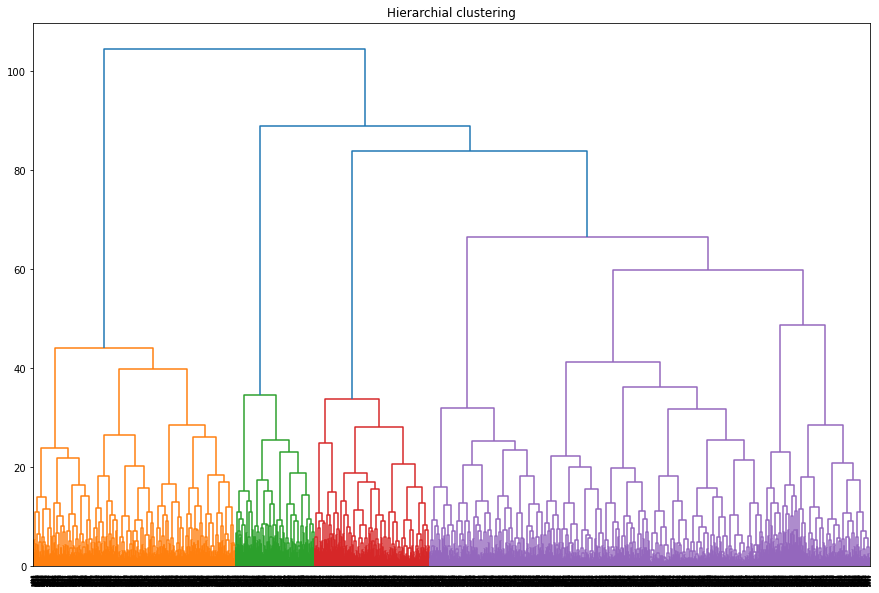

In [16]:
# визуализация
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering')
plt.show() 

Для обучения модели K-Means назначим 5 кластеров как сказано в задании. Судя по дендрограмме и можно также выделить и шестой кластер.
Обучим модель кластеризации на основании алгоритма K-Means и сделаем прогноз кластеров клиентов.

In [17]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_st)

# сохраняем метки кластера в поле нашего датасета
df['Cluster_client'] = labels

Выведем статистику по средним занчениям признаков по кластерам.

In [18]:
# статистика по средним значениям наших признаков по кластеру
clusters = df.groupby(['Cluster_client']).mean()
clusters.T.style.format('{:.2f}', na_rep='-')

Cluster_client,0,1,2,3,4
Gender,0.50,0.52,0.50,0.49,0.56
Near_Location,0.96,0.86,0.00,1.00,0.98
Partner,0.78,0.47,0.46,0.35,0.36
Promo_friends,0.57,0.31,0.08,0.24,0.23
Phone,1.00,0.00,1.00,1.00,1.00
Contract_period,10.89,4.79,2.35,1.95,2.67
Group_visits,0.54,0.43,0.22,0.34,0.47
Age,29.98,29.30,28.48,28.17,30.13
Avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
Month_to_end_contract,9.95,4.48,2.20,1.86,2.46


- клиенты второй группы живут далеко от спорт. клуба;
- нулевая группа пришла по партнёрской программе;
- у второй группы нет промокодов от друзей, а у нулевой их больше всего;
- первая группа не давала номер тлефона;
- нулевая и четвертая группы тратят на доп услуги больше всех;
- больше всего времени после обращения в фитнес-центр прошло у нулевой, первой и четвёртой;
- реже всех ходит вторая и третья группы;

Группы с большим оттоком: 2, 3.

Группы с минимальным оттоком: 0, 3.

Посмотрим на диаграммы распределения признаков по кластерам.

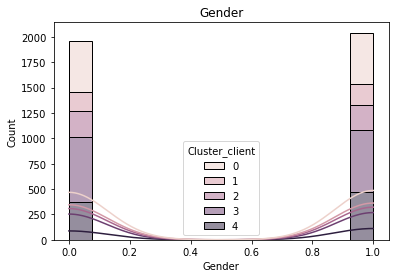

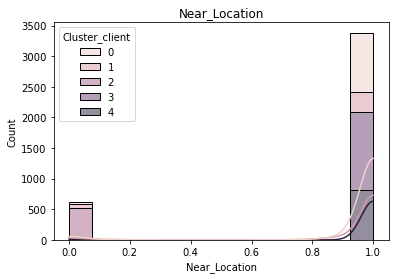

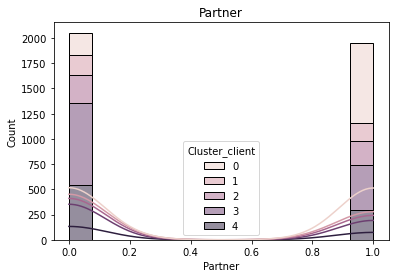

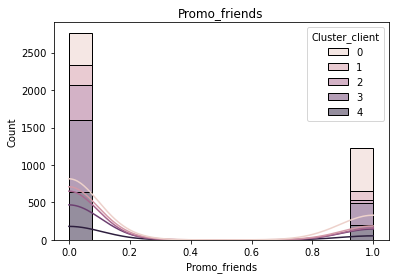

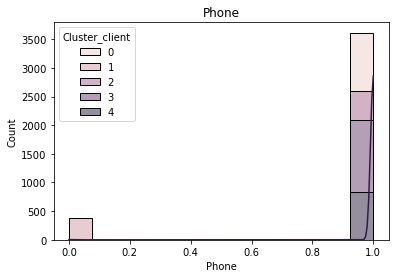

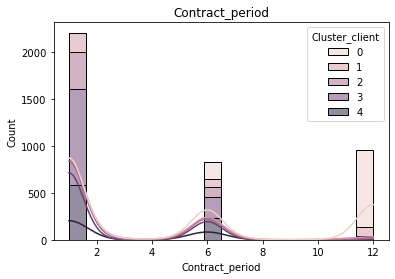

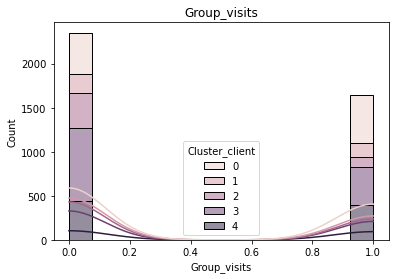

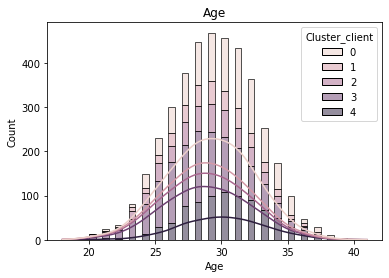

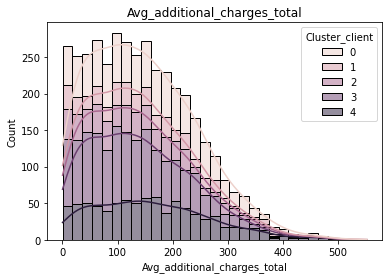

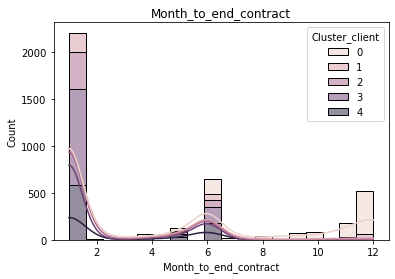

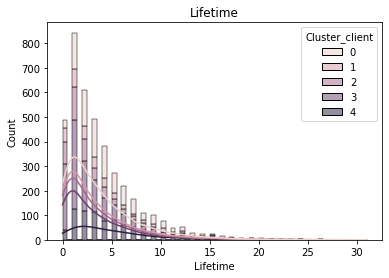

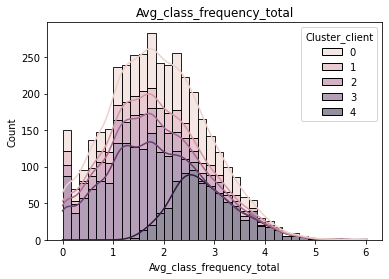

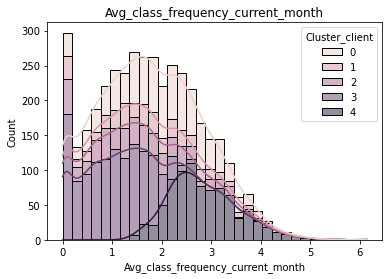

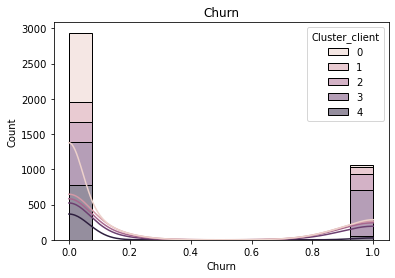

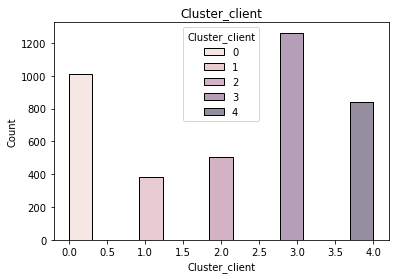

In [19]:
for feature in df.columns:
    sns.histplot(data=df, x=feature, hue='Cluster_client', kde=True, multiple="stack");
    plt.title(feature)
    plt.show(); 

- Для нулевой группы характерно:
    - живут или работают рядом с клубом;
    - большая часть состоит в партнёрской программе;
    - мало клиентов имеют промокоды от друзей;
    - имеют 12-ти месячные контракты;
    - старше остальных групп;
    - много клиентов у которых осталось 12 месяцев до конца контрата - получается в этой групппе клиенты только начали заниматься и она не может быть показательной для определения причин оттока;
    - неплохой лайфтайм.


- Для первой группы характерно:
    - живут или работают рядом с клубом;
    - много клиентов имеют промокоды от друзей;
    - не оставили номер телефона;
    - преимущественно имеют месячный контракт;
    - значительный отток.
    
    
- Для второй группы характерно:
    - живут или работают рядом с клубом;
    - много клиентов имеют промокоды от друзей;
    - меньше остальных групп ходят на групповые занятия;
    - преимущественно имеют месячный контракт;
    - реже остальных кластеров ходят в клуб;
    - большой отток.
    
    
- Для третей группы характерно:
    - значительная часть живёт или работают далеко от фитнес-центра;
    - большая часть состоит в партнёрской программе;
    - много клиентов имеют промокоды от друзей;
    - меньше остальных групп ходят на групповые занятия;
    - преимущественно имеют месячный контракт;
    - реже остальных кластеров ходят в клуб;
    - значительное число клиентов, которые перестают ходить за месяц до оттока;
    - большой отток.
    
    
- Для для четвёртой группы характерно:
    - живут или работают рядом с клубом;
    - большая часть состоит в партнёрской программе;
    - много клиентов имеют промокоды от друзей;
    - преимущественно имеют месячный контракт;
    - старше остальных групп;
    - тратит больше всех на доп. услуги;
    - лайфтайм наибольший и самый "сглаженный"
    - регулярно хояд в клуб.
    
    
Посчитаем для каждого кластера долю оттока.

In [20]:
df_cluster = df.groupby(['Cluster_client'])['Gender'].count().reset_index()
df_churn = df.groupby(['Cluster_client', 'Churn'])['Near_Location'].count().reset_index()
df_churn = df_churn.merge(df_cluster)
df_churn
df_churn.columns = ['Кластер', 'Отток', "Кол-во клиентов по оттоку", "Кол-во клиентов по кластеру"]
df_churn['Доля, %'] = df_churn['Кол-во клиентов по оттоку']/df_churn['Кол-во клиентов по кластеру']
df_churn.style.format({'Доля, %': '{:.2%}'})

,Кластер,Отток,Кол-во клиентов по оттоку,Кол-во клиентов по кластеру,"Доля, %"
0,0,0,982,1010,97.23%
1,0,1,28,1010,2.77%
2,1,0,282,385,73.25%
3,1,1,103,385,26.75%
4,2,0,281,505,55.64%
5,2,1,224,505,44.36%
6,3,0,613,1262,48.57%
7,3,1,649,1262,51.43%
8,4,0,781,838,93.20%
9,4,1,57,838,6.80%


Второй и третий кластеры подверженны оттоку больше. Значительный отток наблюдается у первого кластера. Самые лояльные клиенты сосредоточены в кластерах 0 и 4.

Для отточных кластеров (2, 3) характерны следующие признаки:
- имеют промо от друзей;
- мало ходят на групповые занятия;
- месячный контракт;
- более молодой возраст;
- малый лайфтайм;
- малая частота пользования клубом.

##  Выводы и рекомендации

**Выводы**
- Проведён предварительный анализ данных:
    - Пропусков в данных не обнаружено;
    - 6 призанаков бинарные, не вклюячая целевой;
    - Средний возраст клиентов 29 лет.
- Исследование средних оценок признаков показало следующее:
    - Отток в среднем меньше если:
        - клиенты являются сотрудниками компаний благодаря которым имеют скидки на абонемент ('Partner');
        - имеется факт первоначальной записи в рамках акции «приведи друга» ;
        - клиент посещает групповые занятия;
        - период контракта 6 месяцев;
        - больше тратит на другие услуги;
        - клиент только начал ходить;
        - клиент ходит в клуб 4 месяца с начала первого обращения;
        - клиент ходит в клуб в среднем 2 раза в неделю.
    - Отток в среднем больше если (небинарные признаки):
        - до окончания контракта осталось 2 месяца;
        - клиент ходит в клуб только в течение 1-го месяца с начала первого обращения;
        - клиент ходит в клуб в среднем 1 раз в неделю.
- Исследование распределения клиентов по признакам показало:
    - Гораздо больше клиентов проживет или работает в районе, где находится фитнес-центр. Клиенты живущие и работающие рядом меньше подвержены оттоку.
    - Промокоды от друзей получили примерно половина клиентов. C промокодами отток меньше.
    - Подавляющее большинство дало контактный телефон;
    - Половина клиентов имеют месячные абонементы. Шестимесячные и двенадцатимесячные контракты распределились примрно поровну и отток у них минимальный.
    - С возрастом доля оттока уменьшается.
    - Частота посещений за месяц до оттока в разы увеличивается.
- Построена модель оттока клиентов. Модель случайного леса оказалась немного точнее.
- Проведена кластеризация клиентов на 5 групп:

    - Для нулевой группы характерно:
        - живут или работают рядом с клубом;
        - большая часть состоит в партнёрской программе;
        - мало клиентов имеют промокоды от друзей;
        - имеют 12-ти месячные контракты;
        - старше остальных групп;
        - много клиентов у которых осталось 12 месяцев до конца контрата - получается в этой групппе многие клиенты только начали заниматься;
        - неплохой лайфтайм.
        
    - Для первой группы характерно:
        - живут или работают рядом с клубом;
        - много клиентов имеют промокоды от друзей;
        - не оставили номер телефона;
        - преимущественно имеют месячный контракт;
        - значительный отток.

    - Для второй группы характерно:
        - живут или работают рядом с клубом;
        - много клиентов имеют промокоды от друзей;
        - меньше остальных групп ходят на групповые занятия;
        - преимущественно имеют месячный контракт;
        - реже остальных кластеров ходят в клуб;
        - большой отток.

    - Для третей группы характерно:
        - значительная часть живёт или работают далеко от фитнес-центра;
        - большая часть состоит в партнёрской программе;
        - много клиентов имеют промокоды от друзей;
        - меньше остальных групп ходят на групповые занятия;
        - преимущественно имеют месячный контракт;
        - реже остальных кластеров ходят в клуб;
        - значительное число клиентов, которые перестают ходить за месяц до оттока;
        - большой отток.

    - Для для четвёртой группы характерно:
        - живут или работают рядом с клубом;
        - большая часть состоит в партнёрской программе;
        - много клиентов имеют промокоды от друзей;
        - преимущественно имеют месячный контракт;
        - старше остальных групп;
        - тратит больше всех на доп. услуги;
        - лайфтайм наибольший и самый "сглаженный"
        - регулярно хояд в клуб.

Для отточных кластеров (2, 3) характерны следующие признаки:
- имеют промо от друзей;
- мало ходят на групповые занятия;
- имеют месячный контракт;
- имеют более молодой возраст;
- малый промежуток времени с момента первого обращения в фитнес-центр;
- малая частота пользования клубом.

**Рекомендации**

Отточные клиенты как правило имеют абонемент лишь на один месяц и, видимо, имеют изначально малую мотивацию для регулярных посещений клуба. Таких клиентов следует замотивировать перейти на более длительный контракт. Как можно это сделать? Вот несколько предложений:
1. Сделать простую скидку по окончании месячного абонемента.
2. Сделать скидку на длительные контракты, доп. услуги при условии регулярных посещений клуба. Так, возможно, получится мотивировать, заинтересовать и выработать привычку регулярности занятий спорта у клиента.
3. Можно определять размер скидки в зависимости от количества взятых доп услуг за этот месяц.
4. Разработать игро-поощерительное прилжение (систему). К примеру, если клиент пробежал на беговой дорожке более 50 км в неделю, то получает бесплатный завтрак. Это поможет заинтересовать клиента.